# importing libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import yfinance as yf

## Function to download stock data


In [2]:
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data


# Function to preprocess data and create sequences


In [3]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append((seq, label))
    return np.array(sequences)


# Function to build and train the LSTM model


In [5]:
def build_lstm_model(input_shape, lstm_units, dense_units, learning_rate):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


# Function for hyperparameter tuning

In [30]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

def build_tunable_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('lstm_units', min_value=50, max_value=200, step=50),
                   input_shape=(sequence_length, 1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                    activation='relu'))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def tune_hyperparameters_tuner(train_data, val_data, sequence_length):
    tuner = RandomSearch(
        build_tunable_lstm_model,
        objective='val_loss',
        max_trials=10,  # you can adjust this value
        directory='keras_tuner_dir',
        project_name='stock_price_prediction')

    tuner.search(train_data[0], train_data[1],
                 epochs=50,
                 batch_size=32,
                 validation_data=val_data,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    best_model = tuner.get_best_models(num_models=1)[0]
    best_mse = best_model.evaluate(val_data[0], val_data[1])
    return best_model, best_mse


# Function to predict stock prices



In [8]:
def predict_stock_prices(model, test_data):
    predictions = model.predict(test_data)
    return predictions

#  Main function


In [34]:
def evaluate_model(ticker, start_date, end_date):
    # Download stock data
    stock_data = download_stock_data(ticker, start_date, end_date)

    # Preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

    # Create sequences
    sequence_length = 10
    sequences = create_sequences(scaled_data, sequence_length)

    # Split data into train and validation sets
    train_size = int(len(sequences) * 0.8)
    train_data = sequences[:train_size]
    val_data = sequences[train_size:]
    train_X, train_y = zip(*train_data)
    val_X, val_y = zip(*val_data)

    train_X = np.array(train_X)
    train_y = np.array(train_y)
    val_X = np.array(val_X)
    val_y = np.array(val_y)

    # Reshape the data
    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
    val_X = np.reshape(val_X, (val_X.shape[0], val_X.shape[1], 1))

    # Hyperparameter tuning
    lstm_units_list = [50, 80]
    dense_units_list = [32, 64]
    learning_rate_list = [0.001, 0.01]

    best_model, _ = tune_hyperparameters((train_X, train_y), (val_X, val_y), lstm_units_list, dense_units_list, learning_rate_list, sequence_length)

    # Test the model
    test_data = sequences[train_size - sequence_length:]
    test_X, test_y = zip(*test_data)
    test_X = np.array(test_X)
    test_y = np.array(test_y)

    # Reshape the data
    test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

    predictions = predict_stock_prices(best_model, test_X)

    # Inverse transform the predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    actual_values = scaler.inverse_transform(np.array(test_y).reshape(-1, 1))

    # Only keep the relevant part of actual_values
    actual_values = actual_values[:len(predictions)]

    return actual_values, predictions



In [36]:
if __name__ == "__main__":
    ticker = input("Enter the stock ticker: ")
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    end_date = input("Enter the end date (YYYY-MM-DD): ")

    actual_values, predictions = evaluate_model(ticker, start_date, end_date)



Enter the stock ticker: GOOGL
Enter the start date (YYYY-MM-DD): 2020-01-01
Enter the end date (YYYY-MM-DD): 2024-01-01
[*********************100%***********************]  1 of 1 completed


C:\Users\D\AppData\Local\Temp\ipykernel_10348\1077509186.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


Epoch 1/50
25/25 [==============================] - 3s 28ms/step - loss: 0.1011 - val_loss: 0.0139
Epoch 2/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 3/50
25/25 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 4/50
25/25 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 5/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 6/50
25/25 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 9/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/50
25/25 [==============================] - 1s 22ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 11/

# printing the values

In [57]:
print("Actual Values:", actual_values.flatten())
print()
print("***************************************************************")
print()

print("Predicted Values")
print()

print("Predictions:", predictions.flatten())



Actual Values: [107.63999939  99.37000275  95.01000214  94.56999969  94.61000061
  94.68000031  96.94000244  95.51000214  94.34999847  91.79000092
  91.65000153  90.88999939  89.12999725  89.87000275  90.05999756
  90.36000061  92.          93.65000153  95.12999725  93.86000061
  94.25        92.31999969  90.62999725  91.11000061  93.97000122
  96.11000061 100.31999969 101.62000275 101.22000122 104.91999817
 103.37000275 105.59999847 105.44000244 102.45999908 101.02999878
 101.38999939 100.88999939 103.73000336 104.36000061 104.72000122
 104.47000122 108.41999817 106.44000244 105.34999847 104.63999939
 107.43000031 108.87000275 105.97000122 104.5        104.18000031
 105.29000092 105.41000366 105.97000122 103.84999847 103.70999908
 107.58999634 107.33999634 107.19999695 105.31999969 105.41000366
 104.69000244 105.56999969 107.76999664 107.34999847 111.75
 116.56999969 117.51000214 116.51000214 119.51000214 120.83999634
 122.83000183 122.76000214 125.05000305 122.55999756 120.90000153
 

In [58]:
def plot_results(actual_values, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(actual_values, label='Actual Prices', color='blue', marker='o')
    plt.plot(predictions, label='Predicted Prices', color='red', marker='o')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()


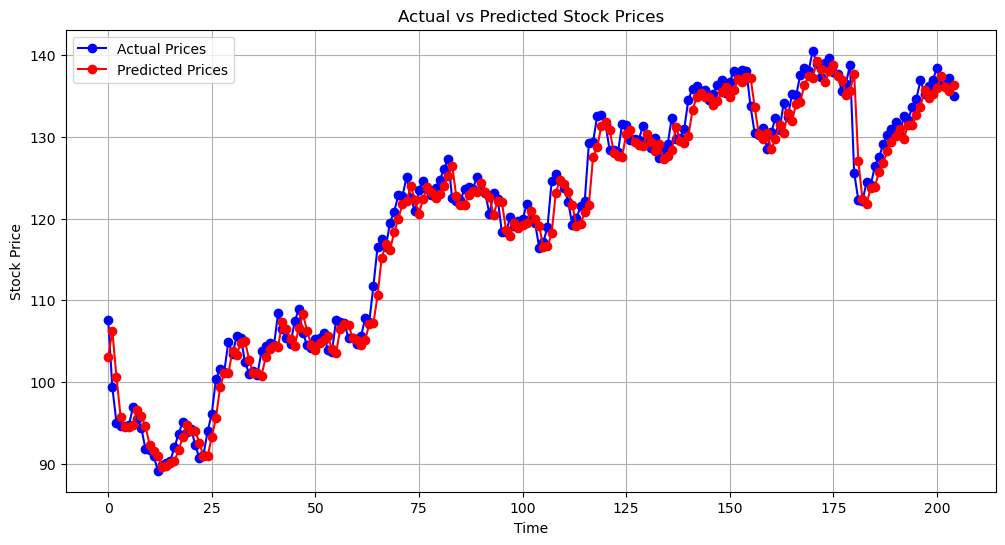

In [59]:
plot_results(actual_values, predictions)